In [1]:
from tf_activation.models import mnist_cff as mnist_model
from tf_activation.experiments import distance_finder
from tf_activation.models.mnist_map import mnist_map

from sklearn.cluster import KMeans
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
persistence_module = tf.load_op_library('/home/tgebhart/python/tensorflow/bazel-bin/tensorflow/core/user_ops/nn_graph_persistence.so')

from time import time
import os
from functools import wraps
import errno
import os
import signal

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
SAVE_PATH = '../logdir/models'
model = 'mnist_cff_2000.ckpt'
NUM_STEPS = 5000
p = 95

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'
config.log_device_placement = False

In [ ]:
# kmeans = KMeans(init='k-means++', n_clusters=len(mnist.train.labels[0]), n_init=10)
# kmeans = KMeans(init='k-means++', n_clusters=50, n_init=10)
# kmeans.fit(mnist.train.images)
# joblib.dump(kmeans, os.path.join(SAVE_PATH, 'kmeans.pkl'))
kmeans = joblib.load(os.path.join(SAVE_PATH, 'kmeans.pkl'))

In [ ]:
class TimeoutError(Exception):
    pass

def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wraps(func)(wrapper)

    return decorator

In [ ]:
@timeout(10)
def per_distance_func(result):
    per_distance = result.eval(feed_dict={x: test_inputs, keep_prob:1.0})
    return per_distance

In [ ]:
df = []
centers = kmeans.cluster_centers_
timeouts = []
with tf.device('/cpu:0'):
        # Create the model
        x = tf.placeholder(tf.float32, [None, 784])

        # Define loss and optimizer
        y_ = tf.placeholder(tf.float32, [None, 10])

        # Build the graph for the deep net
        net, keep_prob = mnist_model.deepnn(x)

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=net['y_conv']))
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(net['y_conv'], 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        saver = tf.train.Saver()
        
with tf.Session(config=config) as sess:

    saver.restore(sess, os.path.join(SAVE_PATH, model))

    for i in range(NUM_STEPS):
        col = {}
        s = kmeans.score(mnist.train.images[i].reshape(1,-1))
        c = centers[kmeans.predict(mnist.train.images[i].reshape(1,-1))][0,:]
        c = centers[kmeans.predict(mnist.train.images[i].reshape(1,-1))][0,:]
        d = np.linalg.norm(c - mnist.train.images[i])
        col['score'] = s
        col['distance'] = d
        col['correct'] = np.argmax(mnist.train.labels[i])
        col['center'] = center_num
    
        test_inputs = np.stack((mnist.train.images[i], c))
        test_labels = np.stack((mnist.train.labels[i], mnist.train.labels[i]))

        percentiles = persistence_module.layerwise_percentile([net['input'],
                                                            net['W_conv1'],
                                                            net['h_conv1'],
                                                            net['h_conv1'],
                                                            net['W_fc1'],
                                                            net['h_fc1'],
                                                            net['h_fc1_drop'],
                                                            net['W_fc2'],
                                                            net['y_conv']],
                                                            [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                            [p,p,p])

        ps1 = percentiles.eval(feed_dict={x: test_inputs[0:1], keep_prob:1.0})
        ps2 = percentiles.eval(feed_dict={x: test_inputs[1:2], keep_prob:1.0})
        
        
        result = persistence_module.wasserstein_distance([net['input'],
                                                            net['W_conv1'],
                                                            net['h_conv1'],
                                                            net['h_conv1'],
                                                            net['W_fc1'],
                                                            net['h_fc1'],
                                                            net['h_fc1_drop'],
                                                            net['W_fc2'],
                                                            net['y_conv']],
                                                            [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                            np.stack((ps1, ps2))
                                                            )
        try:
            per_distance = per_distance_func(result)
        except TimeoutError:
            print('TimeoutError!')
            timeouts.append(i)
            continue
            
#         for j in range(10):
#             test_inputs[1] = mnist.test.images[mnist_map[j]]
#             pst = percentiles.eval(feed_dict={x: test_inputs[1:2], keep_prob:1.0})
#             result = persistence_module.wasserstein_distance([net['input'],
#                                                             net['W_conv1'],
#                                                             net['h_conv1'],
#                                                             net['h_conv1'],
#                                                             net['W_fc1'],
#                                                             net['h_fc1'],
#                                                             net['h_fc1_drop'],
#                                                             net['W_fc2'],
#                                                             net['y_conv']],
#                                                             [0, 1, 2, 2, 1, 4, 4, 1, 4],
#                                                             np.stack((ps1, pst))
#                                                             )
#             try:
#                 per_distance_t = per_distance_func(result)
#             except TimeoutError:
#                 print('TimeoutError!')
#                 continue
        
#             col[j] = per_distance_t[0]
#             print('Image {}, Persistence Distance: {}'.format(j, per_distance_t[0]))
        print('Test Image: {}, Persistence Distance: {}'.format(i, per_distance))

        ce = cross_entropy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = sess.run(net['y_conv'], feed_dict={x:test_inputs[1:], keep_prob:1.0})
        acc = accuracy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1})
        y_conv = y_conv / np.linalg.norm(y_conv)
        
        col['per_distance'] = per_distance[0]
        col['cross_entropy'] = ce
        col['y_conv'] = y_conv[0,np.argmax(test_labels[1], axis=0)]
        col['accuracy'] = acc
        
        df.append(col)

In [3]:
df = pd.read_pickle('../logdir/data/experiments/cluster_mnist/cluster_df.pkl')

In [4]:
# df.head()
df['center'].value_counts()

7    401
1    302
0    292
9    276
4    236
3    232
2    219
5    195
8    184
6    173
Name: center, dtype: int64

In [5]:
def regress(X, y, xlab, ylab, color_vals='b'):

    # Split the data into training/testing sets
    X_train = X[:-20]
    X_test = X[-20:]

    # Split the targets into training/testing sets
    y_train = y[:-20]
    y_test = y[-20:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: ', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))
    print('R^2: %.2f' % r2_score(y_test, regr.predict(X_test)))

    fig, ax = plt.subplots()
    X_min = np.min(X)
    X_max = np.max(X)
    y_min = np.min(y)
    y_max = np.max(y)
    # Plot outputs

    ax.scatter(X, y,  color=color_vals)
    ax.plot(X, regr.predict(X), color='silver', linewidth=3)
#     ax.set_xlim(X_min, X_max)
#     ax.set_ylim(y_min, y_max)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title('{} vs {}'.format(xlab, ylab))

    plt.show()

In [6]:
df.head()

,acc_solo,accuracy,center,correct,cross_entropy,distance,per_distance,score,y_conv
0,1.0,0.5,1,7,3.703134,25.418276,289084.93750,-55.628616,-0.025423
1,1.0,0.5,4,3,4.228854,108.137741,412128.09375,-33.493309,-0.271623
2,1.0,0.5,1,4,3.696519,26.092428,289086.71875,-35.184921,-0.206224
3,1.0,0.5,8,6,3.497449,221.036469,332854.84375,-31.868988,-0.088060
4,1.0,0.5,2,1,2.594356,54.662743,296067.06250,-15.740414,0.095223


('Class:', 0)
('Coefficients: ', array([[ 520.84973409]]))
Mean squared error: 2375239.59
Variance score: -0.44
R^2: -0.44


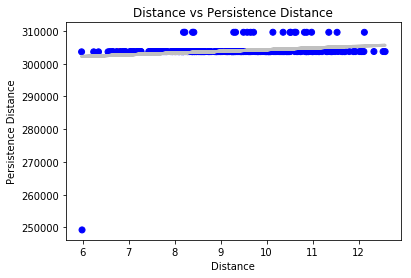

('Class:', 1)
('Coefficients: ', array([[-1637.08675434]]))
Mean squared error: 1510097.74
Variance score: -115433.35
R^2: -115433.35


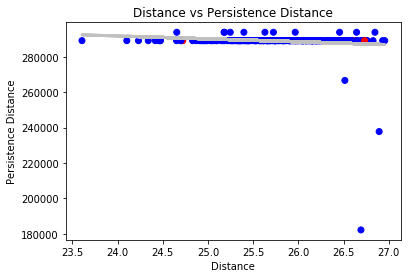

('Class:', 2)
('Coefficients: ', array([[-2381.20182917]]))
Mean squared error: 3461754.20
Variance score: -3537.58
R^2: -3537.58


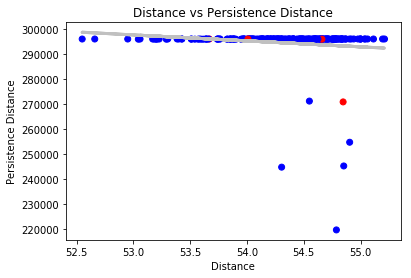

('Class:', 3)
('Coefficients: ', array([[-1428.63744238]]))
Mean squared error: 2027202.74
Variance score: -217311.75
R^2: -217311.75


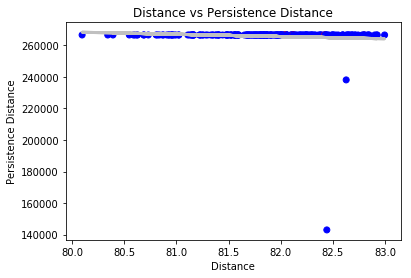

('Class:', 4)
('Coefficients: ', array([[-121.45555727]]))
Mean squared error: 367120.43
Variance score: -14067.98
R^2: -14067.98


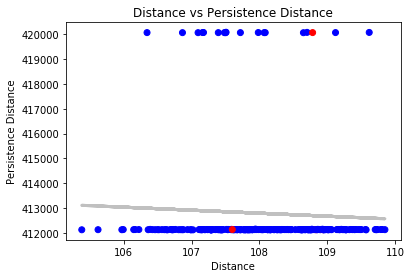

('Class:', 5)
('Coefficients: ', array([[ 0.64517362]]))
Mean squared error: 14.67
Variance score: -0.04
R^2: -0.04


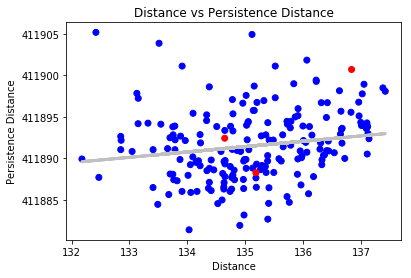

('Class:', 6)
('Coefficients: ', array([[ 1.26145129]]))
Mean squared error: 29.04
Variance score: -0.43
R^2: -0.43


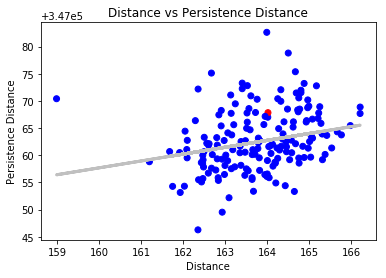

('Class:', 7)
('Coefficients: ', array([[ 0.63216259]]))
Mean squared error: 34.04
Variance score: -0.02
R^2: -0.02


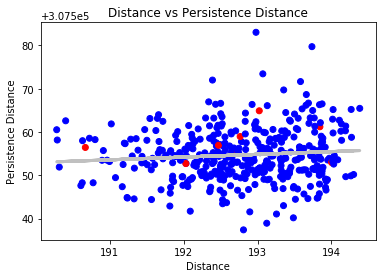

('Class:', 8)
('Coefficients: ', array([[-159.5303263]]))
Mean squared error: 19220294.63
Variance score: -0.04
R^2: -0.04


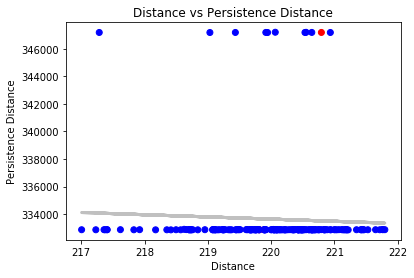

('Class:', 9)
('Coefficients: ', array([[ 0.68810915]]))
Mean squared error: 16.88
Variance score: 0.01
R^2: 0.01


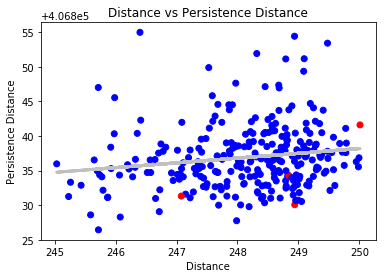

In [7]:
for cls in range(10):
    print('Class:',cls)
    tdf = df[df['center'] == cls]
    color_vals = ['r' if acc == 0.0 else 'b' for acc in df['acc_solo']]
    regress(tdf.as_matrix(columns=['distance']), tdf.as_matrix(columns=['per_distance']), 'Distance', 'Persistence Distance', color_vals=color_vals)